考虑一个testGroupby(A, B, C)表，它所有可能的group by语句的分组属性级有$\{ \{A\}, \{B\}, \{C\}, \{AB\}, \{AC\}, \{BC\}, \{ABC\} \}$，这些属性组之间存在包含关系，比如$\{A\}\subseteq\{AB\}, \{A\}\subseteq\{AC\}$。这些包含关系意味着子属性集可以由父属性集的结果计算得来。比如group by A，既可以从原表中直接计算出来，也可以从group by A,B或group by A,C的结果中计算得来。所以如果我们能保存某些group by的结果，用它来支持其它子属性集的分组操作，那么可以获得更快的执行性能。

如果我们设定缓存的大小，问题就变成针对一个给定的分组查询集合，物化哪些group by的结果可以使得总的IO数最小。

我们形式化地描述这个问题（注意：下面的步骤都是要用SQL完成的）：

1. 创建表testGroupby(A, B, C, D)，设置各属性取值范围分别为1~10, 1~100, 1~1000, 1~10000，除去空集，应该有15个分组属性集.

In [1]:
import sqlite3

conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

# 创建 testGroupby 表, 并添加 CHECK 约束
cursor.execute('''
CREATE TABLE testGroupby (
    A INTEGER NOT NULL CHECK (A BETWEEN 1 AND 10),
    B INTEGER NOT NULL CHECK (B BETWEEN 1 AND 100),
    C INTEGER NOT NULL CHECK (C BETWEEN 1 AND 1000),
    D INTEGER NOT NULL CHECK (D BETWEEN 1 AND 10000)
)
''')

conn.commit()

2. 往表里填充50~100万行数据，这个可以请大模型帮着生成插入模拟数据的脚本，比较简单。

In [2]:
cursor.execute("DELETE FROM testGroupby")
conn.commit()

In [3]:
import random
import time

# 设置插入参数
TOTAL_ROWS = 800_000   # 插入总行数（可调整为 500000 ~ 1_000_000）
BATCH_SIZE = 10_000    # 每批插入多少行

# 开始计时
start_time = time.time()

# 插入数据
inserted = 0
while inserted < TOTAL_ROWS:
    batch = []
    for _ in range(BATCH_SIZE):
        a = random.randint(1, 10)
        b = random.randint(1, 100)
        c = random.randint(1, 1000)
        d = random.randint(1, 10000)
        batch.append((a, b, c, d))

    cursor.executemany("INSERT INTO testGroupby (A, B, C, D) VALUES (?, ?, ?, ?)", batch)
    conn.commit()
    inserted += len(batch)

# 结束计时
end_time = time.time()
print(f"\n✅ 共插入 {inserted} 行数据，耗时 {end_time - start_time:.2f} 秒")


✅ 共插入 800000 行数据，耗时 2.30 秒


3. 查询出15个分组属性集结果的行数，并记入一个表attrSets(attrCode, cardinality) 中，对应着属性集编码和行数。

In [4]:
# 创建用于存储结果的表
cursor.execute('''
CREATE TABLE IF NOT EXISTS attrSets (
    attrCode TEXT PRIMARY KEY,
    cardinality INTEGER NOT NULL
)
''')
conn.commit()

# 所有非空分组属性集
groupings = [
    ['A'], ['B'], ['C'], ['D'],
    ['A','B'], ['A','C'], ['A','D'], ['B','C'], ['B','D'], ['C','D'],
    ['A','B','C'], ['A','B','D'], ['A','C','D'], ['B','C','D'],
    ['A','B','C','D']
]

# 将分组转换为字符串形式作为 attrCode
def get_attr_code(group):
    return ''.join(group)

# 清空历史记录
cursor.execute("DELETE FROM attrSets")
conn.commit()

# 遍历每个分组，执行 GROUP BY 查询并插入结果
for group in groupings:
    group_cols = ', '.join(group)
    sql = f"SELECT COUNT(*) FROM (SELECT 1 FROM testGroupby GROUP BY {group_cols})"
    cursor.execute(sql)
    count = cursor.fetchone()[0]
    attr_code = get_attr_code(group)
    cursor.execute(
        "INSERT INTO attrSets (attrCode, cardinality) VALUES (?, ?)",
        (attr_code, count)
    )
conn.commit()

print("✅ 已成功将所有 group by 的基数写入 attrSets 表中")

# 打印结果查看
cursor.execute("SELECT * FROM attrSets ORDER BY attrCode")
for row in cursor.fetchall():
    print(row)

✅ 已成功将所有 group by 的基数写入 attrSets 表中
('A', 10)
('AB', 1000)
('ABC', 550710)
('ABCD', 799961)
('ABD', 768815)
('AC', 10000)
('ACD', 796940)
('AD', 99963)
('B', 100)
('BC', 99953)
('BCD', 799681)
('BD', 550647)
('C', 1000)
('CD', 769180)
('D', 10000)


4. 随机产生一个工作负载集workloads，里面包含着若干分组查询。可以从第3步里面的attrSets中随机产生若干行作为负载集。

In [5]:
def generate_workload_table(conn, workload_size=10):
    """
    随机从 attrSets 中采样若干条记录作为 workloads 表的数据。

    参数：
        conn: SQLite 数据库连接
        workload_size: 要采样的查询数

    返回：
        queries: list[str] - 被采样的 attrCode 列表（即查询负载）
    """
    cur = conn.cursor()
    cur.execute("SELECT attrCode FROM attrSets")
    all_attrCodes = [row[0] for row in cur.fetchall()]
    
    if workload_size > len(all_attrCodes):
        raise ValueError("workload_size 超过可用属性集合数量")

    samples = random.sample(all_attrCodes, workload_size)

    cur.execute("DROP TABLE IF EXISTS workloads")
    cur.execute("CREATE TABLE workloads (attrCode TEXT)")
    cur.executemany("INSERT INTO workloads VALUES (?)", [(code,) for code in samples])
    conn.commit()

    return samples


5. 针对这个负载集，在一定缓存空间的限制下，选取物化哪些分组的查询结果会使得整体的IO数量最小？

In [6]:
def greedy_materialize_selection(conn, queries, cache_limit=30000):
    """
    基于贪心策略选择物化视图集合，以最小化查询的IO成本

    参数：
        conn: SQLite3 数据库连接
        queries: 工作负载中的 group by 属性集合列表，例如 ['A', 'AB', 'CD']
        cache_limit: 缓存容量限制，单位为 cardinality 总和（视为近似 I/O 成本）

    返回：
        cached_views: 被物化的属性集合代码（如 {'ABC', 'BD'}）
        total_io_cost: 当前负载在该缓存方案下的总IO成本
        used_space: 实际使用的缓存空间
    """
    cur = conn.cursor()
    
    # 加载所有视图候选及其大小
    cur.execute("SELECT attrCode, cardinality FROM attrSets")
    card_map = {row[0]: row[1] for row in cur.fetchall()}

    # 建立每个候选视图所能支持的查询集合（包含关系）
    from collections import defaultdict
    support_map = defaultdict(set)
    for view in card_map:
        for q in queries:
            if set(q).issubset(set(view)):
                support_map[view].add(q)

    cached_views = set()
    covered_queries = set()
    used_space = 0

    # 贪心选择过程
    while covered_queries != set(queries):
        best = None
        best_score = 0
        for view, supported in support_map.items():
            if view in cached_views:
                continue
            new_queries = supported - covered_queries
            size = card_map[view]
            if size + used_space > cache_limit:
                continue
            if size == 0:
                continue  # 避免除以0
            score = len(new_queries) / size  # 单位缓存支持查询数
            if score > best_score:
                best = view
                best_score = score

        if not best:
            break  # 无法再加入新视图

        cached_views.add(best)
        used_space += card_map[best]
        covered_queries.update(support_map[best])

    # 计算总IO成本：每个查询尝试从最小超集物化视图中获得支持
    total_io_cost = 0
    for q in queries:
        candidates = [v for v in cached_views if set(q).issubset(set(v))]
        if candidates:
            total_io_cost += min(card_map[v] for v in candidates)
        else:
            total_io_cost += card_map[q]  # fallback：从原始数据计算

    return cached_views, total_io_cost, used_space


6. 尝试不同的负载集和不同缓存空间的大小，对比一下结果。
7. （选做）讨论这个通用的解法是什么？

In [7]:
def evaluate(conn, workload_sizes, cache_limits, trials_per_setting=3):
    """
    尝试不同的负载规模和缓存空间限制，比较贪心策略的IO成本表现。

    参数：
        conn: SQLite连接
        workload_sizes: list[int]，如 [5, 10, 15]
        cache_limits: list[int]，如 [5000, 10000, 20000]
        trials_per_setting: 每种组合尝试的次数（结果取平均）

    返回：
        pandas.DataFrame，包含每个实验组合的平均 IO 成本、缓存使用等信息
    """
    results = []

    for wsize in workload_sizes:
        for climit in cache_limits:
            total_io = 0
            total_cache = 0
            for _ in range(trials_per_setting):
                queries = generate_workload_table(conn, workload_size=wsize)  # 生成并写入workloads表
                views, io_cost, used_cache = greedy_materialize_selection(conn, queries, cache_limit=climit)
                total_io += io_cost
                total_cache += used_cache

            results.append({
                "workload_size": wsize,
                "cache_limit": climit,
                "avg_io_cost": total_io / trials_per_setting,
                "avg_cache_used": total_cache / trials_per_setting
            })

    import pandas as pd
    return pd.DataFrame(results)


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

def plot_evaluation_results(df):
    """
    将 evaluate 输出的 DataFrame 可视化。
    
    参数：
        df: pandas.DataFrame，包含 workload_size、cache_limit、avg_io_cost、avg_cache_used 列
    """ 
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 折线图：不同 cache_limit 下的 IO 成本（按 workload_size 分组）
    sns.lineplot(
        data=df,
        x="cache_limit", y="avg_io_cost",
        hue="workload_size", marker="o",
        ax=axes[0]
    )
    axes[0].set_title("IO Cost vs Cache Limit")
    axes[0].set_xlabel("Cache Size")
    axes[0].set_ylabel("Average IO Cost")

    # 折线图：缓存使用量
    sns.lineplot(
        data=df,
        x="cache_limit", y="avg_cache_used",
        hue="workload_size", marker="o",
        ax=axes[1]
    )
    axes[1].set_title("Cache Usage vs Cache Limit")
    axes[1].set_xlabel("Cache Size")
    axes[1].set_ylabel("Average Cache Used")

    plt.tight_layout()
    plt.show()



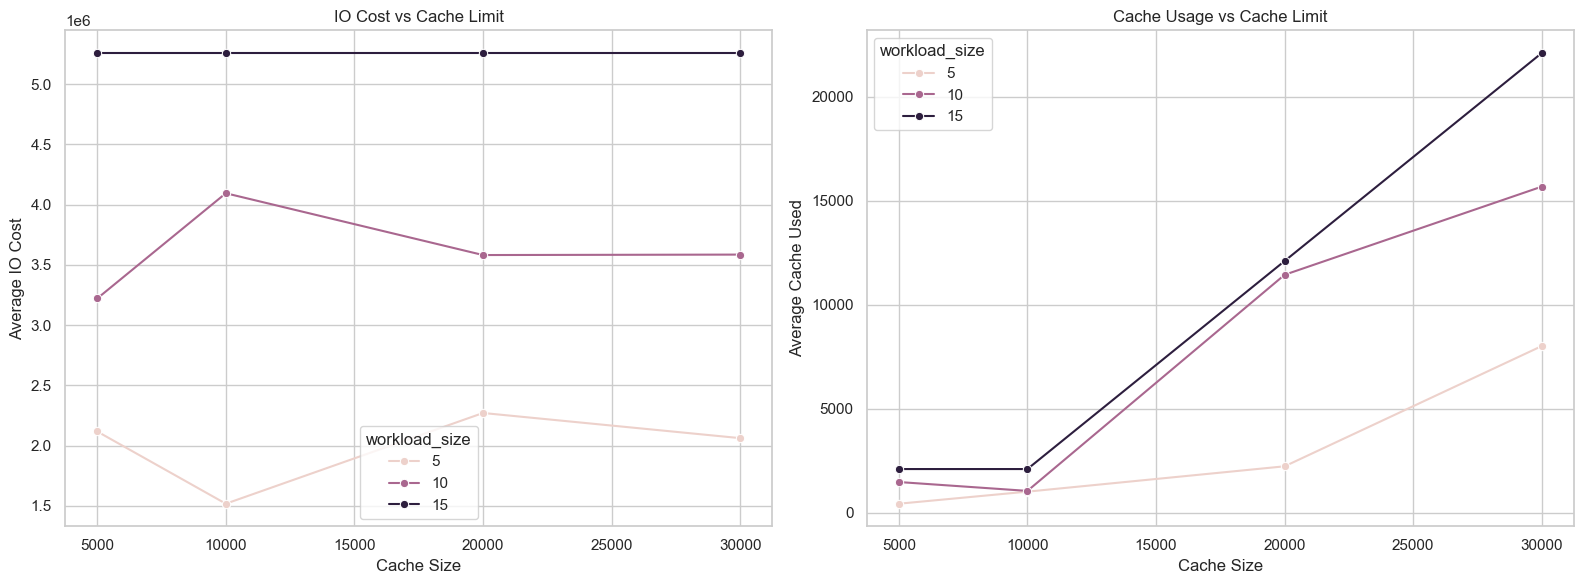

In [9]:
df = evaluate(
    conn,
    workload_sizes=[5, 10, 15],
    cache_limits=[5000, 10000, 20000, 30000],
    trials_per_setting=5
)

plot_evaluation_results(df)
